

*   Muhammad Kristover Armand
*  mkarmand43@gmail.com



In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

# Download and extract dataset
!wget -q https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
with zipfile.ZipFile('rockpaperscissors.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Define paths
base_dir = 'rockpaperscissors/rps-cv-images'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.4
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)

# Transfer Learning with VGG16
base_model = tf.keras.applications.VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: rock, paper, scissors
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Custom callback to stop training at 96% accuracy
class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        if current_accuracy is not None and current_accuracy >= self.target_accuracy:
            self.model.stop_training = True
            print(f"\nStopping training as validation accuracy reached {self.target_accuracy * 100:.2f}%")

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
stop_training_at_accuracy = StopTrainingAtAccuracy(target_accuracy=0.96)


Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, stop_training_at_accuracy]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.4710 - loss: 1.1331 - val_accuracy: 0.8099 - val_loss: 0.6164 - learning_rate: 1.0000e-04
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.7266 - loss: 0.6526

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7266 - loss: 0.6526 - val_accuracy: 0.8113 - val_loss: 0.6278 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7716 - loss: 0.6188 - val_accuracy: 0.8646 - val_loss: 0.4112 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8125 - loss: 0.5170 - val_accuracy: 0.8868 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8293 - loss: 0.4409 - val_accuracy: 0.9141 - val_loss: 0.3001 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8672 - loss: 0.3445 - val_accuracy: 0.8679 - val_loss: 0.3587 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8783 - loss: 0.3488 - val_accuracy: 0.9427 - val_loss: 0.2285 - learning_rate: 1.0000e-04
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8750 - loss: 0.3489

In [3]:

# Print training and validation accuracy
print("Final Training Accuracy: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Final Validation Accuracy: {:.2f}%".format(history.history['val_accuracy'][-1] * 100))

Final Training Accuracy: 92.19%
Final Validation Accuracy: 96.23%


In [4]:
model.save('nama_model.h5')


In [5]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt

Saving 0a3UtNzl5Ll3sq8K.png to 0a3UtNzl5Ll3sq8K.png


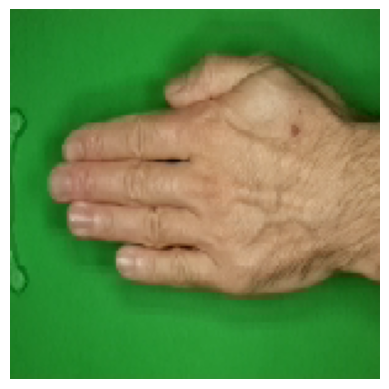

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
0a3UtNzl5Ll3sq8K.png: paper


In [6]:

# Image prediction
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    # Interpret the results
    class_labels = ['paper', 'rock', 'scissors']
    predicted_class = class_labels[np.argmax(classes)]
    print(f"{fn}: {predicted_class}")